### Import modules

In [1]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import preprocessing
from sklearn.utils.multiclass import unique_labels
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import yaml
import my_py_tools
from werkzeug.utils import secure_filename # https://blog.csdn.net/weixin_44493841/article/details/107864437
from my_py_tools.yaml.yaml import YAML
from my_py_tools.plt.barh import plot_horizontal_bar
from my_py_tools.numpy.frequencies import get_frequencies
from my_py_tools.image.size_manupilation import resize_with_zero_padding, random_crop
plt.style.use('seaborn')


class MyModelTool:
    #
    CONFIG_PATH = "config.yaml"
    ATTRS = ['hp', 'pa', 'ma', 'sp', 'cr']

    #
    def __init__(self):
        # Read configure
        self.config = YAML(MyModelTool.CONFIG_PATH).get_data()

        # Load rating record
        self.df_record = pd.read_csv(self.config['path']['data']['rating_record'])

        # Make each attribute's dataframe (name, image, attribute)
        self.df_attrs = {}
        for attr in MyModelTool.ATTRS:
            self.df_attrs[attr] = self.df_record.filter(['name', 'image', attr], axis=1)

        #
    # Plot how many images each rater has rated
    def plot_how_many_images_each_rater_has_rated(self):
        rater_to_num = self.df_record.groupby('name').size()
        plot_horizontal_bar(rater_to_num.values,
                            rater_to_num.index.values,
                            x_label='Number of images has rated',
                            title='How many images each rater has rated?',
                            show=False
                            )


    # See if there's anything outside the distribution range (0~10)
    def rating_distribution_of_all_attrs(self):
        print("Valid range: 0~10")
        for attr in MyModelTool.ATTRS:
            frequencies, unique, counts = get_frequencies(data=self.df_record[attr].values, return_unique_and_counts=True)
            min_uniq, max_uniq = min(unique.tolist()), max(unique.tolist())
            print("Attribute {}: min={}, max={} => {}".format(attr, min_uniq, max_uniq,
                                                              "VALID" if min_uniq >= 0 and max_uniq <= 10 else "INVALID"))
            plt.figure(figsize=(10,2))
            plt.bar([x[0] for x in frequencies], [x[1] for x in frequencies])
            plt.show()

    # Plot each rater's rating distribution of each attribute
    def plot_each_rater_rating_distribution_of_each_attribute(self):
        for attr in self.ATTRS:
            # Group and collect as lists
            # https://stackoverflow.com/questions/22219004/how-to-group-dataframe-rows-into-list-in-pandas-groupby
            rater_to_attrSet = self.df_attrs[attr].groupby(['name'])[attr].apply(list)
            rater_num = len(rater_to_attrSet) # Number of raters
            rater_hp_distributions = {}
            for i in range(rater_num):
                (unique_nums, counts) = np.unique(np.array(rater_to_attrSet.values[i]), return_counts=True)
                unique_nums, counts = unique_nums.tolist(), counts.tolist()
                frequencies = {unique_nums[i]: counts[i] for i in range(len(unique_nums))}
                distribution = []
                for j in range(0, 11): # 0~10
                        distribution.append(0) if j not in frequencies else distribution.append(frequencies[j])
                rater_hp_distributions[rater_to_attrSet.index[i]] = distribution
            df = pd.DataFrame(data=rater_hp_distributions)
            ax = df.plot.bar(stacked=True, figsize=(15,10), fontsize=20)
            ax.legend(prop={'size': 20}) # Set legend size
            title = "Each rater's rating distribution of {}".format(attr)
            ax.set_title(label=title, fontdict={'fontsize': 30}) # Set title
            plt.savefig(os.path.join(self.config['path']['statistics'],secure_filename(title)))

    #
    def get_file_path(self, file_name):
        return os.path.join(self.config['path']['data']['all_images'], file_name)

    #
    def jjj(self):
        from my_py_tools.image.size_manupilation import resize_with_zero_padding, random_crop
        # https://www.geeksforgeeks.org/selecting-rows-in-pandas-dataframe-based-on-conditions/

        #
        # Warning: All image will be turned into RGB in default.

        epochs = config['train']['epoch']
        # TODO: batch_size='all'
        # batch_size = config['train']['batch_size'] if config['train']['batch_size'] != 'all' else
        batch_size = config['train']['batch_size']
        input_size = (config['input']['input_size']['width'], config['input']['input_size']['height'])
        input_color_format = config['input']['color'] # Image color format
        #
        use_random_crop = config['train']['random_crop']['use_random_crop']
        random_crop_resize = (config['train']['random_crop']['resize']['width'],
                                config['train']['random_crop']['resize']['height'])
        # Get PIL color mode
        pil_color_mode = None
        if input_color_format == 'RGB':
            pil_color_mode = 'RGB'
        elif input_color_format == 'Grayscale':
            pil_color_mode = 'LA'
        else:
            raise ValueError('Invalid input color format.')

        clf = RandomForestClassifier(verbose=0, n_jobs=-1, n_estimators=100)

        model = clf

        #######################################

        def my_train(x_train, x_test_data, y_train, y_test):
            X_train = x_train
            X_test_data = x_test_data
            X_train_size = X_train.size
            iterations = X_train_size // batch_size if X_train_size % batch_size == 0 else X_train_size // batch_size + 1
            print(" ^^^^^^ Fold-{} ^^^^^^ \n".format(i+1))
            print('Epochs: {}'.format(epochs))
            print('Batch size: {}'.format(batch_size))
            print('Total iterations: {}'.format(iterations))
            print('Input size(w,h): ({},{})'.format(input_size[0], input_size[1]))
            print()

            # Epochs
            for cur_epoch_num in range(1, epochs + 1):
                print('Epoch {}'.format(cur_epoch_num))
                accumulated_x = 0
                # Iteration
                for cur_iteration_num in range(1, iterations + 1):
                    print('+++++ iteration {}\r'.format(cur_iteration_num))
                    cur_iteration_x_num = min(batch_size, X_train_size - accumulated_x)
                    X_batch_data = []
                    y_batch_data = []
                    for cur_x_number in range(1, cur_iteration_x_num + 1):
                        # Get img
                        idx = accumulated_x + cur_x_number - 1
                        file_path = os.path.join(config['path']['data']['all_images'],
                                                 X_train[idx])
                        img = None
                        if use_random_crop == 'true':
                            img = random_crop(img=file_path,
                                              bbox_size=input_size,
                                              input_mode='file_path',
                                              min_size=random_crop_resize,
                                              all_possible=False,
                                              return_mode='PIL_Image')

                        else:
                            img = resize_with_zero_padding(img=file_path,
                                                                       input_mode='file_path',
                                                                       target_size=input_size,
                                                                       return_mode='PIL_Image')
                        # Image color format
                        img = img.convert(pil_color_mode)
                        # Put batch datas in the current batch
                        X_batch_data.append(np.array(img).flatten())
                        y_batch_data.append(y_train[idx])
                    X_batch_data = np.array(X_batch_data)
                    y_batch_data = np.array(y_batch_data)
                    # Train
                    model.fit(X_batch_data, y_batch_data)

                # Validation
                y_pred = model.predict(X_test_data)
                accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
                print()
                print("+++++ Epoch accuracy score: {}".format(accuracy))


        #######################################
        for attr in config['attributes']:
            print("=== Attribute {} ===\n".format(attr))
            df_liao = df_attrs[attr][df_attrs[attr]['name']=='liao']
            # Drop zero
            df_liao = df_liao[df_liao[attr]!=0]

            # Make X and y (X here only represents image file names.)
            # X = []
            # y = [v for v in df_liao[attr].values]
            # target_w_and_h = (config['input']['input_size']['width'], config['input']['input_size']['height']) #(30, 36)
            # for img_name in df_liao['image'].values:
            #     X.append(resize_with_zero_padding(img=os.path.join(config['path']['data']['all_images'], img_name),
            #                                       input_mode='file_path',
            #                                       target_size=target_w_and_h,
            #                                       return_mode='array'))
            # X = np.array(X)
            # y = np.array(y)
            X = [name for name in df_liao['image'].values]
            y = [v for v in df_liao[attr].values]
            X = np.array(X)
            y = np.array(y)


            # K-fold
            K = config['train']['K_fold_number']
            # TODO: K <= 1
            # folds = []
            # if K > 1:
            #     pass
            # else:
            #     folds.append([0, np.arange()])
            kf = KFold(n_splits=K)
            total_accuracy = 0
            total_confusion_matrices = []
            for i, (train_idx, test_idx) in enumerate(kf.split(X)):
                # TODO K<=1, train_test_split
                # [i, train_idx, test_idx] = fold

                # Get fold
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]

                # Get X_test_data
                X_test_data = []
                for x_test_file in X_test:
                    X_test_data.append(np.array(resize_with_zero_padding(img=get_file_path(file_name=x_test_file),
                                             input_mode='file_path',
                                             target_size=input_size,
                                             return_mode='PIL_Image').convert(pil_color_mode)).flatten())
                X_test_data = np.array(X_test_data)


                my_train(X_train, X_test_data, y_train, y_test)

                # Calculate validation accuracy
                y_pred = model.predict(X_test_data)
                accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
                print("This fold's accuracy score: {}".format(accuracy))
                total_accuracy += accuracy
                total_confusion_matrices.append(confusion_matrix(y_test, y_pred, labels=np.arange(11)))
                print()

            print("Avg accuracy score: {:.3f}\n".format(total_accuracy/K))

            # Add all confusion matrices
            cm_after_added = total_confusion_matrices[0]
            for i in range(1, len(total_confusion_matrices)):
                cm_after_added = np.add(cm_after_added, total_confusion_matrices[i])

            # Determine whether to formalize
            if config['confusion_matrix']['normalize'] == 'true':
                cm_after_added = cm_after_added / (np.linalg.norm(cm_after_added))

            # Plot confusion matrix
            import seaborn as sn
            plt.rcdefaults()
            font={'size':40}
            matplotlib.rc('font', **font)
            plt.figure(figsize=(50,35))
            cm_description = 'Attribute="{}", epochs={}, batch_size={}, size=(w,h)=({},{}), color="{}"'.format(
                attr, epochs, batch_size, input_size[0], input_size[1], input_color_format)
            random_crop_description = 'False' if use_random_crop == False \
                else 'True, min_size(w,h)=({},{})'.format(random_crop_resize[0], random_crop_resize[1])
            cm_description = cm_description + ', {}'.format(random_crop_description)
            plt.title(cm_description)
            _ = sn.heatmap(pd.DataFrame(data=cm_after_added,
                                    index=list(np.arange(11)),
                                    columns=list(np.arange(11))),
                        annot=True,
                        cmap=plt.cm.Blues,
                        fmt='.{}'.format(config['confusion_matrix']['round_precision'])
                        )
            plt.savefig('statistics/{}'.format(cm_description))


a = MyModelTool()

In [ ]:
# # Read configures
# from my_py_tools.yaml.yaml import YAML
# CONFIG_PATH = "config.yaml"
# config = YAML(CONFIG_PATH).get_data()
# print(config)

### Load rating recorrd

In [4]:
# # Load rating record
# df_record = pd.read_csv(config['path']['data']['rating_record'])
#
# # Make each attribute's dataframe (name, image, attribute)
# attrs = ['hp', 'pa', 'ma', 'sp', 'cr']
# df_attrs = {}
# print("Show all dataframes' head 1:")
# for attr in attrs:
#     df_attrs[attr] = df_record.filter(['name', 'image', attr], axis=1)
#     print(df_attrs[attr].head(1))

Show all dataframes' head 1:
   name                image  hp
0  shih  nba_players_290.png  10
   name                image  pa
0  shih  nba_players_290.png   7
   name                image  ma
0  shih  nba_players_290.png   3
   name                image  sp
0  shih  nba_players_290.png   9
   name                image  cr
0  shih  nba_players_290.png   8


### Observe the data

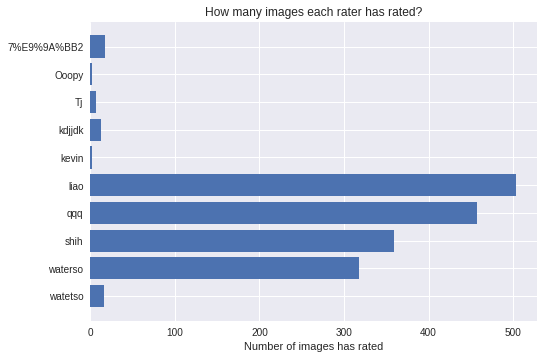

In [5]:
# # Plot how many images each rater has rated
# from my_py_tools.plt.barh import plot_horizontal_bar
# rater_to_num = df_record.groupby('name').size()
# plot_horizontal_bar(rater_to_num.values,
#                     rater_to_num.index.values,
#                     x_label='Number of images has rated',
#                     title='How many images each rater has rated?',
#                     show=False
#                     )
'''
a = MyModelTool()
a.plot_how_many_images_each_rater_has_rated()
'''

Valid range: 0~10
Attribute hp: min=0, max=10 => VALID
Attribute pa: min=0, max=10 => VALID
Attribute ma: min=0, max=10 => VALID
Attribute sp: min=0, max=10 => VALID
Attribute cr: min=0, max=10 => VALID


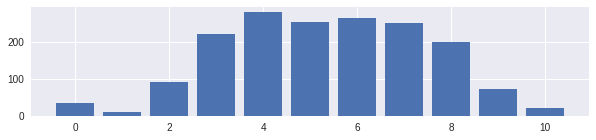

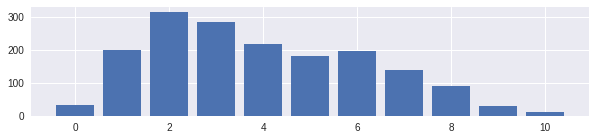

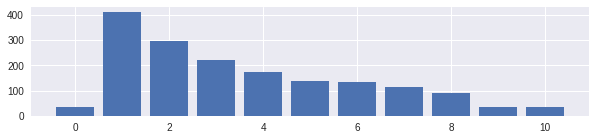

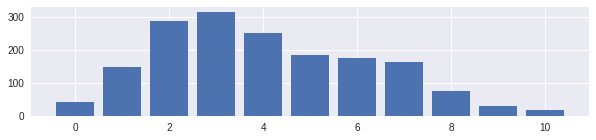

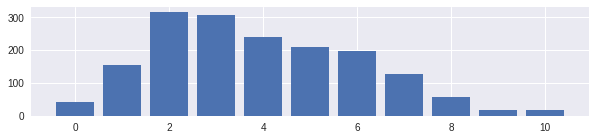

In [6]:
# # See if there's anything outside the distribution range (0~10)
# from my_py_tools.numpy.frequencies import get_frequencies
# print("Valid range: 0~10")
# for attr in attrs:
#     frequencies, unique, counts = get_frequencies(data=df_record[attr].values, return_unique_and_counts=True)
#     min_uniq, max_uniq = min(unique.tolist()), max(unique.tolist())
#     print("Attribute {}: min={}, max={} => {}".format(attr, min_uniq, max_uniq,
#                                                       "VALID" if min_uniq >= 0 and max_uniq <= 10 else "INVALID"))
#     plt.figure(figsize=(10,2))
#     plt.bar([x[0] for x in frequencies], [x[1] for x in frequencies])
#     plt.show()
'''
a = MyModelTool()
a.rating_distribution_of_all_attrs()
'''

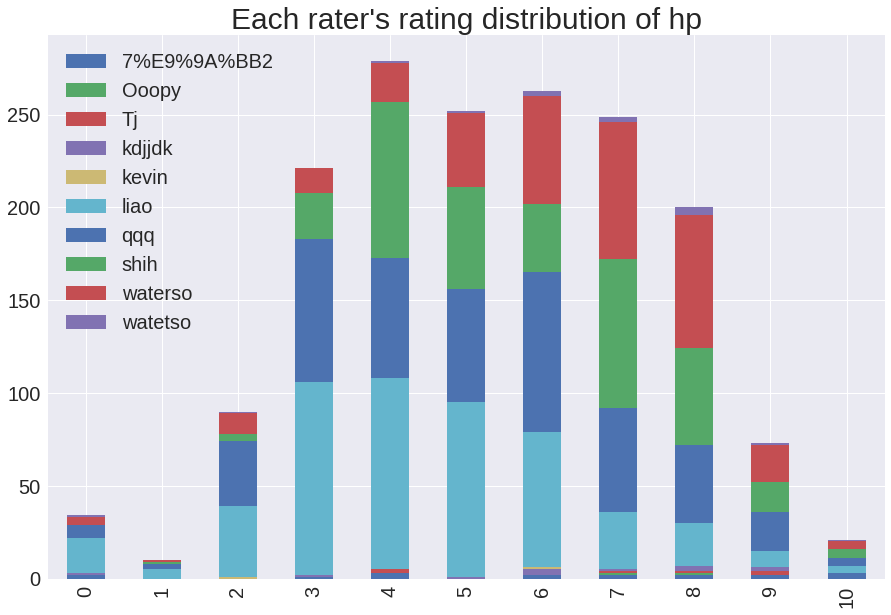

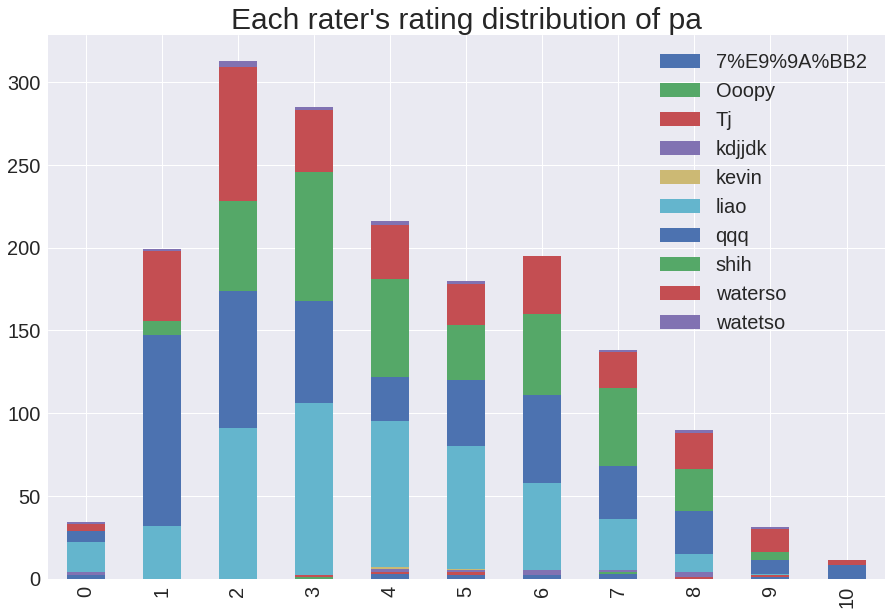

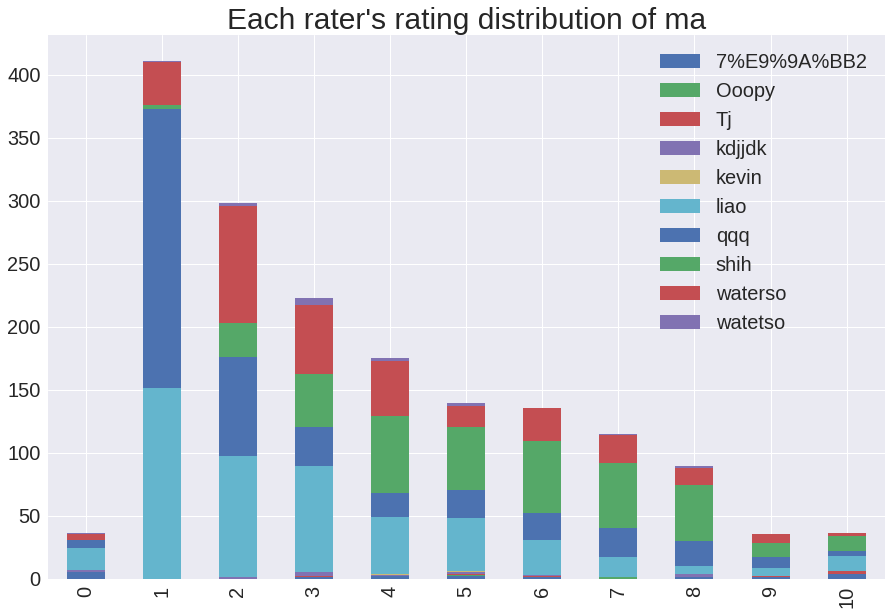

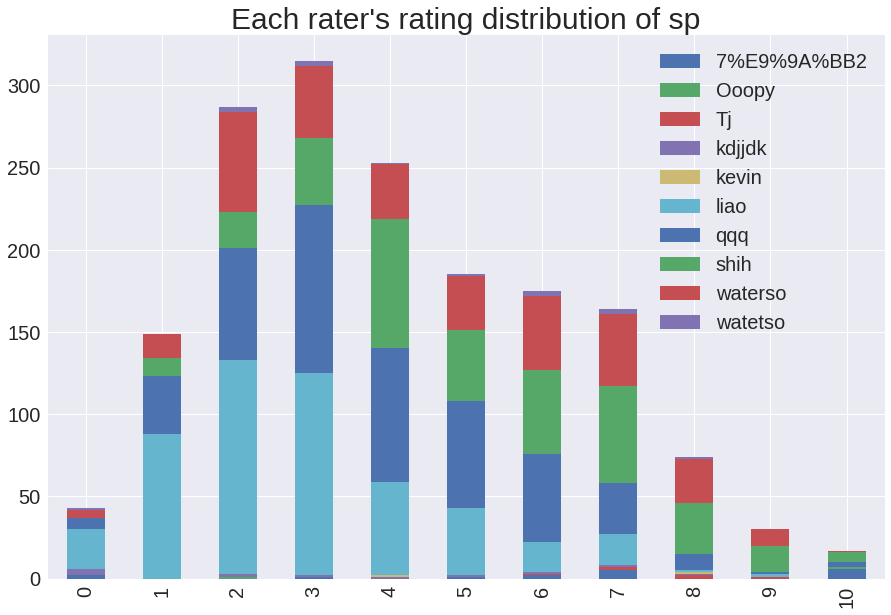

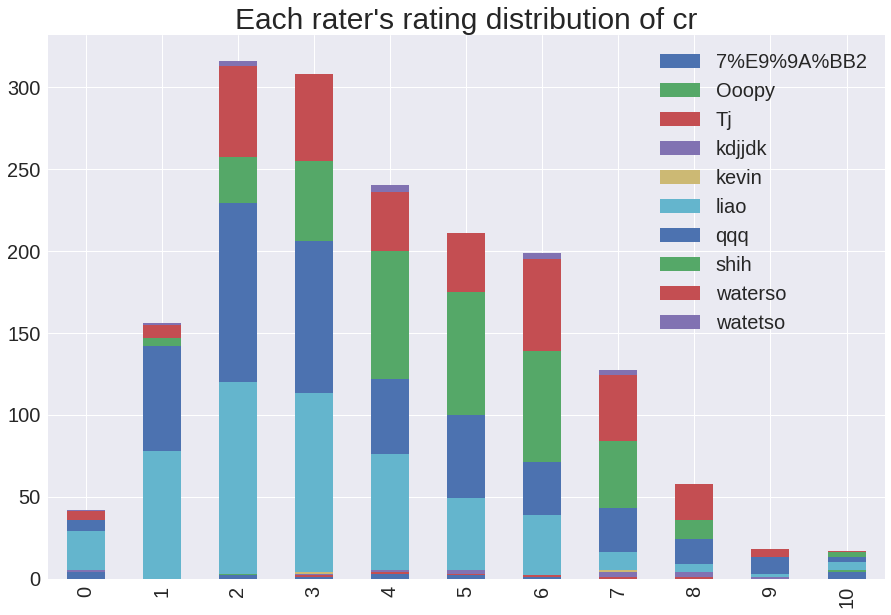

In [7]:
# # Plot each rater's rating distribution of each attribute
# for attr in attrs:
#     # Group and collect as lists
#     # https://stackoverflow.com/questions/22219004/how-to-group-dataframe-rows-into-list-in-pandas-groupby
#     rater_to_attrSet = df_attrs[attr].groupby(['name'])[attr].apply(list)
#     rater_num = len(rater_to_attrSet) # Number of raters
#     rater_hp_distributions = {}
#     for i in range(rater_num):
#         (unique_nums, counts) = np.unique(np.array(rater_to_attrSet.values[i]), return_counts=True)
#         unique_nums, counts = unique_nums.tolist(), counts.tolist()
#         frequencies = {unique_nums[i]: counts[i] for i in range(len(unique_nums))}
#         distribution = []
#         for j in range(0, 11): # 0~10
#                 distribution.append(0) if j not in frequencies else distribution.append(frequencies[j])
#         rater_hp_distributions[rater_to_attrSet.index[i]] = distribution
#     df = pd.DataFrame(data=rater_hp_distributions)
#     ax = df.plot.bar(stacked=True, figsize=(15,10), fontsize=20)
#     ax.legend(prop={'size': 20}) # Set legend size
#     title = "Each rater's rating distribution of {}".format(attr)
#     ax.set_title(label=title, fontdict={'fontsize': 30}) # Set title
#     plt.savefig(os.path.join(config['path']['statistics'],secure_filename(title)))
'''
a = MyModelTool()
a.plot_each_rater_rating_distribution_of_each_attribute()
'''

Frist try: all pixels are independent features
compress to 178(h) * 278(w)
#TODO:
- Try one attribute; after fininshing try others
- Think how to define invalid data and how to use them
- Split into train and validation set
- Try use all img and try use all images of a specific rater
- Try small group, like nba_players, professors......
- Design hyper-params
- Extra: other models, eg. KNN, decision tree
- Better if turned into gray-scale images?

### Try liao's rating in attr "hp"

In [9]:
# def get_file_path(file_name):
#     return os.path.join(config['path']['data']['all_images'], file_name)






NameError: name 'RandomForestClassifier' is not defined

In [26]:
regr = RandomForestRegressor(random_state=0, verbose=1, n_jobs=-1, n_estimators=100)
# regr.fit(X, y)
regr.fit(np.array([x.flatten() for x in X_train ]), y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.8s finished


RandomForestRegressor(n_jobs=-1, random_state=0, verbose=1)

In [28]:
y_pred = regr.predict(np.array([x.flatten() for x in X_test]))
# print(regr.predict([[0, 0, 0, 0]]))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [29]:
# Make float be int (< .5 ; >= .5 )
y_pred2 = np.array([int(y) if (y-float(int(y)) < 0.5) else int(y) + 1 for y in y_pred ])
#%
from sklearn.metrics import r2_score, accuracy_score

# print(r2_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred2))

0.20618556701030927


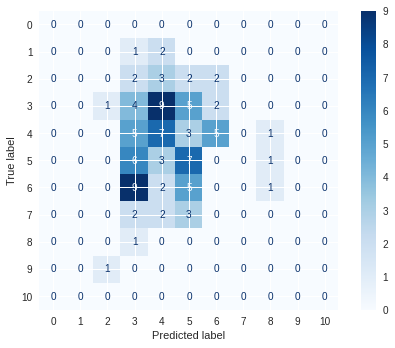

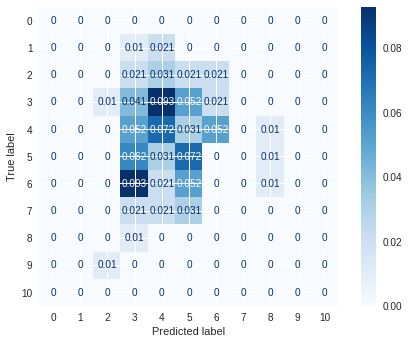

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

clf = RandomForestClassifier(verbose=0, n_jobs=-1, n_estimators=100)

X_train_flatten = np.array([x.flatten() for x in X_train])
X_test_flatten = np.array([x.flatten() for x in X_test])
from sklearn.metrics import plot_confusion_matrix
clf.fit(X_train_flatten, y_train)
for normalize in [None, 'all']:
    plot_confusion_matrix(clf, X_test_flatten, y_test, cmap=plt.cm.Blues, labels=np.arange(11),
                          normalize=normalize)


In [ ]:
y_pred_clf = clf.predict(np.array([x.flatten() for x in X_test]))

print("Accurcy score:",accuracy_score(y_test, y_pred_clf))
from sklearn.metrics import plot_confusion_matrix

np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, np.array([x.flatten() for x in X_test]),
                                 y_test,
                                 # display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    # print(title)
    # print(disp.confusion_matrix)

plt.show()


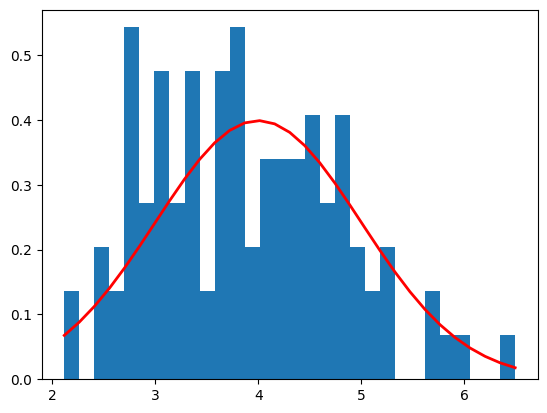

0.2079207920792079


In [70]:
mu, sigma = 4,1
s = np.random.normal(mu, sigma, 101)
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()
# a = 1/(sigma * np.sqrt(2 * np.pi)) *   np.exp( - (bins - mu)**2 / (2 * sigma**2) )
# s_y = np.array([ 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ) for ss in s])
sss = np.array([int(ss) if (ss-float(int(ss)) < 0.5) else int(ss) + 1 for ss in s])
y_pred_normal = sss.copy()
print(accuracy_score(y_test, y_pred_normal))

In [81]:
rand_numbers = []
for i in range(101):
    rand_numbers.append(randint(3,6))
rand_numbers = np.array(rand_numbers)
print(accuracy_score(y_test, rand_numbers))

0.21782178217821782


In [15]:
iii = Image.open('data/images/100116.jpg')
iii.show()
print(iii.size)

(178, 218)


In [3]:
from my_py_tools.image.size_manupilation import resize_with_zero_padding

In [4]:
kkk = resize_with_zero_padding(img='data/images/100116.jpg', input_mode='file_path', target_width=300, target_height=360, return_mode='PIL_Image')
kkk.show()

In [4]:
from my_py_tools.image.size_manupilation import random_crop
for i in range(10):
    random_crop(img='data/images/100116.jpg', bbox_size=(300,300),
            input_mode='file_path', min_size=(1000,500), all_possible=False,
            return_mode='PIL_Image'
            ).show()


In [17]:
# regr = RandomForestRegressor(random_state=0, verbose=1, n_jobs=-1)
# # regr.fit(X, y)
# regr.fit(np.array([x.flatten() for x in X ]), y)
# # RandomForestRegressor(...)
# # print(regr.predict([[0, 0, 0, 0]]))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished


RandomForestRegressor(n_jobs=-1, random_state=0, verbose=1)

In [18]:
iii = Image.open('data/images/184682.jpg')
iii.show()
np.array(iii).shape

(218, 178, 3)

In [19]:
# Flatten
aaaaa = X[0]
bbbbb = aaaaa.flatten()

Important: I convert all images into jpg when resizing

In [20]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.datasets import make_regression
# X, y = make_regression(n_features=1, n_informative=2,
#                        random_state=0, shuffle=False)

# regr = RandomForestRegressor(max_depth=2, random_state=0)
# regr.fit(X, y)
# RandomForestRegressor(...)
# print(regr.predict([[0, 0, 0, 0]]))


In [5]:
from PIL import Image
import numpy as np
img = Image.open('/home/smallfish/Pictures/22222.png')
a = np.array(img)
img = img.convert('RGB')
print(a.shape)
print(np.array(img).shape)
print(img.mode)


(1033, 1060, 4)
(1033, 1060, 3)
RGB
